I initally sketched out my code plan with the notes below, which I ended up following pretty closely.

In [34]:
# Initial code outline

# Load data
# Clean up latitude and longitude fields
# Limit the dates
# Make an initial map
# Add different colors to break the days up

In [35]:
# imports
import json
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point


seed = 0

Location data was downloaded from my friend's google account and shared with me. Instructions for how to access that data are [here](https://support.google.com/accounts/answer/3024190?hl=en). For privacy reasons, I haven't uploaded the json location data file.

# Data Loading

In [36]:
f = open("location_history.json")
location_history = json.load(f)
df = pd.json_normalize(location_history['locations'])

Let's look quickly at the data; I'll choose a sample of coordinates out west:

In [37]:
(df.loc[(df.loc[:, 'latitudeE7'] > 430000000) & (df.loc[:, 'longitudeE7'] < -760000000)]).sample(random_state = seed, n=5)

,timestampMs,latitudeE7,longitudeE7,accuracy,altitude,activity,velocity,heading
14970,1505513790000,437353203,-1034841796,6,1544.0,NaN,13.0,2.0
7642,1505672517000,465022567,-904847830,4,300.0,NaN,27.0,118.0
9397,1505640852999,462804273,-926640634,4,320.0,NaN,0.0,310.0
17354,1505413737000,442139436,-1061578524,8,1188.0,"[{'timestampMs': '1505413729915', 'activity': ...",0.0,141.0
31566,1504864347361,509518662,-1202339753,3400,NaN,NaN,NaN,NaN


Look pretty clean already. Let's understand the data types:

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289798 entries, 0 to 289797
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestampMs  289798 non-null  object 
 1   latitudeE7   289798 non-null  int64  
 2   longitudeE7  289798 non-null  int64  
 3   accuracy     289798 non-null  int64  
 4   altitude     103098 non-null  float64
 5   activity     130588 non-null  object 
 6   velocity     92723 non-null   float64
 7   heading      88201 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 17.7+ MB


After some digging, I [found](https://locationhistoryformat.com/reference/records/) what each field means. My data file doesn't have all of the listed fields, so perhaps he shared a more limited file with me or not all of the current fields were available at the time he pulled the data. It's helpful to know the units for each field and understand what the activity field means.

Let's take a look at some of the other fields.

In [39]:
df.loc[:,['velocity', 'altitude']].max()

velocity      48.0
altitude    4294.0
dtype: float64

In [40]:
df.loc[:,['velocity', 'altitude']].min()

velocity      0.0
altitude   -305.0
dtype: float64

In [41]:
df.loc[df.loc[:, 'altitude'] == df.loc[:, 'altitude'].max()]

,timestampMs,latitudeE7,longitudeE7,accuracy,altitude,activity,velocity,heading
66260,1503589990585,388402197,-1050435205,48,4294.0,"[{'timestampMs': '1503589959602', 'activity': ...",0.0,33.0


In [42]:
df.loc[df.loc[:, 'velocity'] == df.loc[:, 'velocity'].max()]

,timestampMs,latitudeE7,longitudeE7,accuracy,altitude,activity,velocity,heading
25427,1505091880000,479568638,-1122971707,4,1189.0,NaN,48.0,157.0


The max values seem reasonable.

Velocity is in meters/second, which would put his max velocity at about 107 miles per hour along a straight section of highway in Montana. Definitely reasonable knowing him.

Likewise, altitude is in meters and puts his highest point at [Pike's Peak](https://en.wikipedia.org/wiki/Pikes_Peak). Interesting to note that Google's elevation is within a few meters of the listed elevation.

The minimum value for altitude is probably some sort of glitch -- it's hard to believe he got to -305 meters below sea level, and the latitude and longitude for that point (which I checked but don't share here) don't make sense. That's a good reminder that the data might be pretty good, but there can still be issues.

# Data Cleaning and Prep

I need to get the dates in the right formats and pull out the month and day to label the map.

In [43]:
# Time is in POSIX * 1000 (milliseconds) format, convert it to useful scale and pull out day and month
# https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date
df.loc[:, 'timestamp'] = df.loc[:, 'timestampMs'].astype(str).astype(int) / 1000
df.loc[:, 'date_and_time'] = df.loc[:, 'timestamp'].apply(lambda x: dt.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df.loc[:, 'day'] = pd.to_datetime(df.loc[:, 'date_and_time']).copy().dt.day 
df.loc[:, 'month'] = pd.to_datetime(df.loc[:, 'date_and_time']).copy().dt.month 

# Convert longitude and lattitude
df.loc[:, 'latitude'] = df.loc[:, 'latitudeE7'].copy() / 1e7
df.loc[:, 'longitude'] = df.loc[:, 'longitudeE7'].copy()  / 1e7

The data the friend shared with me spans a year -- we can look at his locations for the entire year. That's not necessary for this work though, so let's limit it to the dates for the trip.

In [44]:
# Keep only the relevant data
df = df.loc[(df.loc[:, 'date_and_time'] >= '2017-08-19') & 
                (df.loc[:, 'date_and_time'] <= '2017-09-21')]

One last thing to check on, out of curiosity -- let's check the number of rows per day during the trip. That gives us an idea of how frequently his phone is recording data, starting with the average:

In [45]:
df.loc[:, ['month', 'day', 'timestampMs']].groupby(['month' , 'day']).count().mean()

timestampMs    2369.969697
dtype: float64

Almost 100 times per hour! Let's look by day:

In [46]:
df.loc[:, ['month', 'day', 'timestampMs']].groupby(['month' , 'day']).count()

timestampMs
month day             
8     19          2382
      20          1944
      21          2057
      22          2862
      23          2522
      24          1904
      25          2140
      26          2320
      27           995
      28           564
      29          1974
      30          1061
      31          2775
9     1           2863
      2           5219
      3           3243
      4           2420
      5           2929
      6           2204
      7           2169
      8           2447
      9           2344
      10          1636
      11          2507
      12          1917
      13          2412
      14          2415
      15          1834
      16          3098
      17          4866
      18          2567
      19          2023
      20          1596

I wonder if the frequency is connected to phone service or whether he's connected to wifi at certain times. Unclear at this juncture, but it's surprising to me how frequently it's recording.

I played around with a few different ways to make the map before settling on the process below. The process in [this blog](https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db) is the easiest, but a little less elegant. [This blog](https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73) outlined how to work with shapefiles, where we can have a little more control over the geographic data. Had to rack my brain to try to remember some concepts from my ArcGIS class from undergrad.

I saw that geopandas comes with datasets, so I took a look:

<AxesSubplot:>

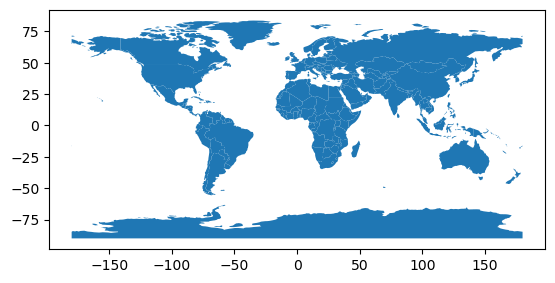

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

That module is deprecated, and we don't get state boundaries, which I want.

Ultimately, I decided to just find the right shapefile and downloaded the file. I haven't uploaded those files to Github (nor the actual location json file, obviously), but I downloaded the shapefile directly from [this site](https://hifld-geoplatform.opendata.arcgis.com/datasets/bee7adfd918e4393995f64e155a1bbdf/explore).

# Making The Maps

In [48]:
NA_map = gpd.read_file('Political_Boundaries_(Area)/Political_Boundaries__Area_.shp')
NA_map

,FID,BOUND_P_,UIDENT,NAME,COUNTRY,STATEABB,Shape_Leng,GlobalID,SHAPE_Le_1,SHAPE_Area,geometry
0,1,1102.0,108304.0,Alaska,USA,US-AK,0.404197,{3C521AFD-2696-4B5D-BD40-D0128410E2D8},51063.662982,-1.092466e+08,"POLYGON ((-19586671.430 6773021.442, -19588997..."
1,2,1103.0,108404.0,Alaska,USA,US-AK,0.672107,{1F968C77-9ED6-4C59-A302-D024D042EE9E},89949.138970,-2.217712e+08,"POLYGON ((-19589640.260 6765341.347, -19590046..."
2,3,1104.0,108504.0,Alaska,USA,US-AK,0.506421,{C03155D0-BBB8-4E9B-8CDD-D1F39455CBA0},73557.545517,-3.648148e+08,"POLYGON ((-19620236.759 6759470.104, -19626458..."
3,4,1106.0,108704.0,Alaska,USA,US-AK,0.351545,{AD624015-EE22-49C8-BE0B-B9823865D19A},48729.892679,-1.800326e+08,"POLYGON ((-19896880.264 6757266.856, -19897229..."
4,5,1108.0,108904.0,British Columbia / Colombie-Britannique,CAN,CA-BC,0.163345,{BDCE5468-CE27-470C-84EB-9F60F40B3DCD},24350.928842,-3.580970e+07,"POLYGON ((-14251514.655 6754030.039, -14252543..."
...,...,...,...,...,...,...,...,...,...,...,...
1826,1828,1607.0,158104.0,Bahamas,FN,NaN,0.121443,{2A057AE5-D091-4845-BB54-2F34C7373E2B},14377.948537,-1.063448e+07,"POLYGON ((-8361149.378 2730808.522, -8361531.5..."
1827,1829,1608.0,158204.0,Bahamas,FN,NaN,0.415354,{9C8FF39D-51E5-417A-B3DD-A1EAFBAA45E0},47472.621077,-1.108095e+08,"POLYGON ((-8342432.575 2711398.584, -8342737.8..."
1828,1830,1609.0,158304.0,Bahamas,FN,NaN,0.129556,{BADC3539-20B1-4D09-B672-73E39C055BFC},15159.998527,-1.468505e+07,"POLYGON ((-8466932.644 2713748.509, -8467522.2..."
1829,1831,1610.0,158404.0,Bahamas,FN,NaN,2.320680,{1226AA77-DDD6-4DA6-A56A-B49049010D90},272481.784147,-6.154115e+08,"POLYGON ((-8332715.383 2614225.453, -8335002.9..."


<AxesSubplot:>

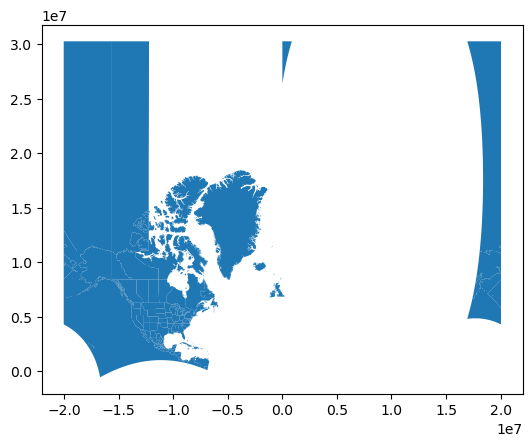

In [49]:
NA_map.plot()

The shapefile looks like what I want. Let's check the actual geographies in the rows:

In [50]:
NA_map.loc[:, 'STATEABB'].unique()

array(['US-AK', 'CA-BC', 'US-MN', nan, 'US-WA', 'US-MT', 'US-ND', 'US-ID',
       'US-WI', 'CA-NU', 'US-OR', 'US-SD', 'US-WY', 'CA-ON', 'US-IA',
       'US-NE', 'US-CA', 'US-UT', 'US-NV', 'US-CO', 'US-MO', 'US-KS',
       'US-AZ', 'CA-NT', 'US-OK', 'US-NM', 'US-TX', 'US-AR', 'US-LA',
       'MX-BCN', 'MX-SON', 'MX-CHH', 'MX-COA', 'MX-BCS', 'MX-NLE',
       'MX-TAM', 'MX-SIN', 'MX-DUR', 'CA-YT', 'US-FL', 'MX-ZAC', 'MX-SLP',
       'MX-NAY', 'MX-JAL', 'MX-VER', 'MX-AGU', 'US-HI', 'MX-GUA',
       'MX-YUC', 'MX-ROO', 'MX-QUE', 'MX-HID', 'MX-CAM', 'MX-PUE',
       'MX-MIC', 'MX-MEX', 'MX-TLA', 'MX-COL', 'MX-MOR', 'MX-GRO',
       'MX-OAX', 'MX-TAB', 'MX-CHP', 'US-IL', 'US-IN', 'US-WV', 'US-VA',
       'US-KY', 'US-TN', 'US-NC', 'US-SC', 'US-AL', 'US-GA', 'US-MS',
       'CA-AB', 'CA-SK', 'CA-MB', 'US-MI', 'US-OH', 'CA-NL', 'CA-QC',
       'CA-NB', 'US-ME', 'CA-PE', 'CA-NS', 'US-NH', 'US-VT', 'US-NY',
       'US-MA', 'US-PA', 'US-CT', 'US-RI', 'US-NJ', 'US-DE', 'US-MD'],
      dtype=object)

Note the nan values (the fourth in the list). It took me some trial and error to find this, but that nan value is the polygons for the Great Lakes. I want to exclude those from my final base map -- I want the Great Lakes to appear as empty space -- so I'm going to drop those.

In [51]:
NA_map = NA_map.loc[NA_map.loc[:, 'STATEABB'].notna()]
NA_map.loc[:, 'STATEABB'].unique()

array(['US-AK', 'CA-BC', 'US-MN', 'US-WA', 'US-MT', 'US-ND', 'US-ID',
       'US-WI', 'CA-NU', 'US-OR', 'US-SD', 'US-WY', 'CA-ON', 'US-IA',
       'US-NE', 'US-CA', 'US-UT', 'US-NV', 'US-CO', 'US-MO', 'US-KS',
       'US-AZ', 'CA-NT', 'US-OK', 'US-NM', 'US-TX', 'US-AR', 'US-LA',
       'MX-BCN', 'MX-SON', 'MX-CHH', 'MX-COA', 'MX-BCS', 'MX-NLE',
       'MX-TAM', 'MX-SIN', 'MX-DUR', 'CA-YT', 'US-FL', 'MX-ZAC', 'MX-SLP',
       'MX-NAY', 'MX-JAL', 'MX-VER', 'MX-AGU', 'US-HI', 'MX-GUA',
       'MX-YUC', 'MX-ROO', 'MX-QUE', 'MX-HID', 'MX-CAM', 'MX-PUE',
       'MX-MIC', 'MX-MEX', 'MX-TLA', 'MX-COL', 'MX-MOR', 'MX-GRO',
       'MX-OAX', 'MX-TAB', 'MX-CHP', 'US-IL', 'US-IN', 'US-WV', 'US-VA',
       'US-KY', 'US-TN', 'US-NC', 'US-SC', 'US-AL', 'US-GA', 'US-MS',
       'CA-AB', 'CA-SK', 'CA-MB', 'US-MI', 'US-OH', 'CA-NL', 'CA-QC',
       'CA-NB', 'US-ME', 'CA-PE', 'CA-NS', 'US-NH', 'US-VT', 'US-NY',
       'US-MA', 'US-PA', 'US-CT', 'US-RI', 'US-NJ', 'US-DE', 'US-MD'],
      dtype=object)

<AxesSubplot:>

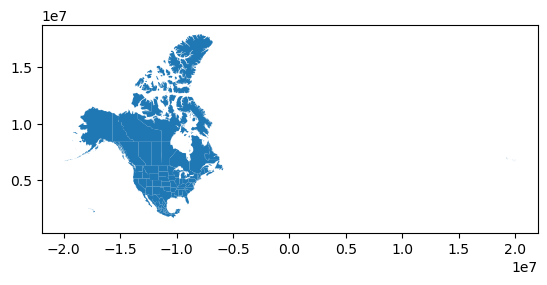

In [52]:
NA_map.plot()

And we can see they're gone!

Next, I need to change the [coordinate reference system](https://geopandas.org/en/stable/docs/user_guide/projections.html) so that it matches the scale or the travel data. 

In [53]:
print(NA_map.crs)
NA_map = NA_map.to_crs('EPSG:4326')
print(NA_map.crs)
NA_map.crs


EPSG:3857
EPSG:4326


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next, I want to calculate the approximate midpoints of each day of the trip, so that I can roughly align the labels at those points.

Taking the mean of each month/day combination yielded the best label locations.

In [54]:
daily_middle_coordinates = df.groupby(['month', 'day'])[['latitude', 'longitude']].mean().reset_index()

I also want to define the borders of the map. Using the same scale factor for all sides of the map made it easy to play around with the map size.

In [55]:
# Get the dimensions of the map
scale_factor = 3.0

BBox = (df.loc[:, 'longitude'].min() - scale_factor,   
        df.loc[:, 'longitude'].max() + scale_factor,      
         df.loc[:, 'latitude'].min() - scale_factor, 
         df.loc[:, 'latitude'].max() + scale_factor)
BBox

(-127.4140046, -73.4962497, 30.1132711, 56.0341892)

Ok now I can finally make the map. I've omitted the trial and error that went into deciding how I wanted the map to look. First I make a function to set up our basic map. I can take its outputs and customize the map from there.

In [56]:
def make_graph_constants(figsize_inputs):
    """
    Make a base map for further customization

    Inputs:
        figsize_inputs (tuple of integers): the dimensions for the map image

    Returns: 
        fig, ax (matplotlib objects): the base of the map
    """
    fig, ax = plt.subplots(figsize = figsize_inputs)
    # Make the background map a light grey
    NA_map.plot(ax=ax, color='lightgrey')

    # Add darker outlines to the state borders
    NA_map.plot(ax=ax, facecolor='none', edgecolor='darkgrey', linewidth=1)

    # Set dimensions and title of the map
    ax.set_xlim(BBox[0], BBox[1])
    ax.set_ylim(BBox[2], BBox[3])

    return fig, ax, 

# Map of Daily Progress

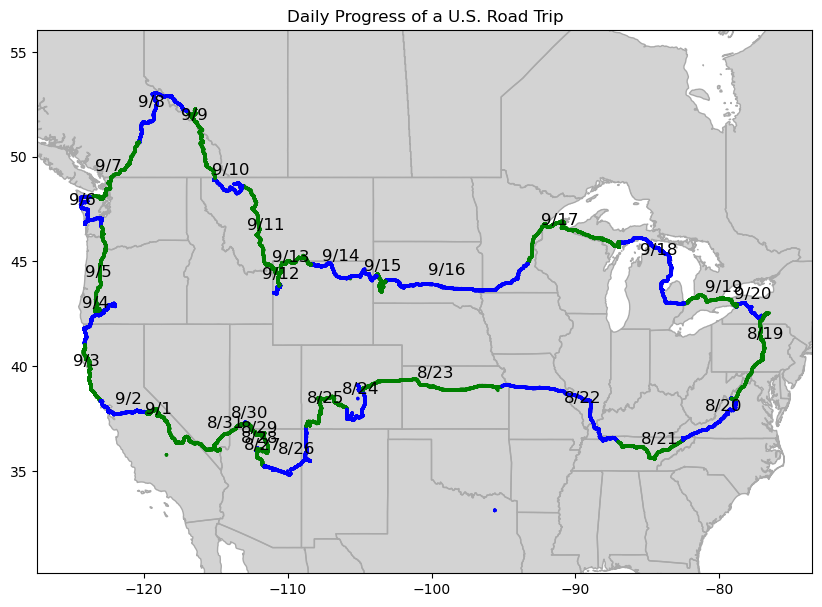

In [57]:
fig, ax = make_graph_constants((10, 10))
ax.set_title("Daily Progress of a U.S. Road Trip")

# Define color of the route based on odd/even days
df.loc[:, 'day_alternating'] = np.where(df.loc[:, 'day'] % 2 == 0, 'b', 'g')
ax.scatter(df.loc[:, 'longitude'], df.loc[:, 'latitude'], s = 2, c = df.loc[:, 'day_alternating'] )

# Now, add date labels to the graph
month_loc = daily_middle_coordinates.columns.to_list().index('month')
day_loc = daily_middle_coordinates.columns.to_list().index('day')
lat_loc = daily_middle_coordinates.columns.to_list().index('latitude')
long_loc = daily_middle_coordinates.columns.to_list().index('longitude')

for row in daily_middle_coordinates.itertuples(index=False):
    y = row[lat_loc]
    x = row[long_loc]
    day_date = str(row[month_loc]) + '/' + str(row[day_loc])
    plt.plot(x, y, color = 'lightgrey')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , day_date, fontsize=12)

plt.savefig('map.png')
plt.show()

I think it looks good! I'm glad I could get the every other day colors and date labels working.

Now that I have the basics set up and my curiosity is piqued, I can look at a few other types of maps. Altitude is easily available, let's take a quick look at that.

# Map of Route Altitude

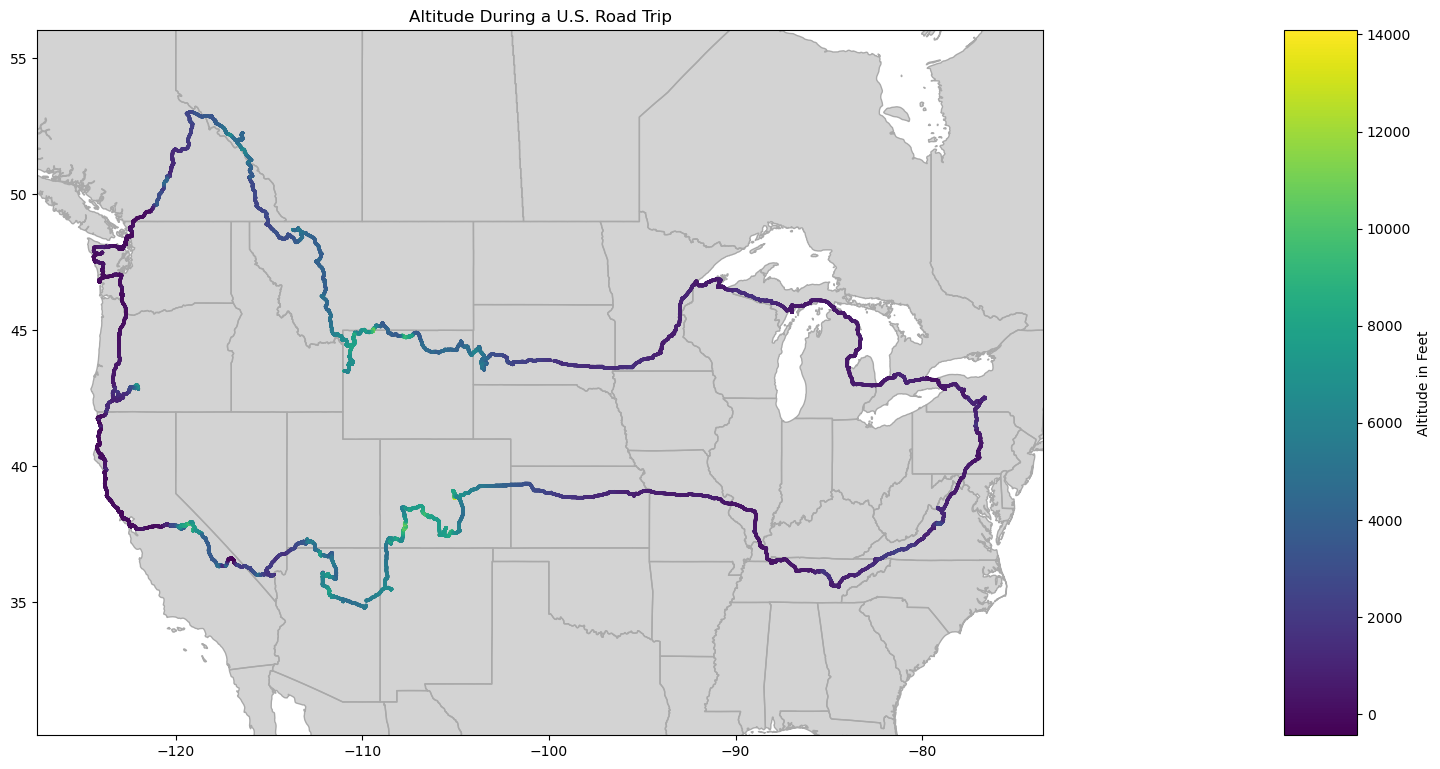

In [58]:
fig, ax = make_graph_constants((20, 20))
ax.set_title("Altitude During a U.S. Road Trip")

# Define color of the route based on altitude in feet; 3.28 feet/meter
scatter = ax.scatter(df.loc[:, 'longitude'], df.loc[:, 'latitude'], s = 2, c = df.loc[:, 'altitude'] * 3.28084)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
colorbar = plt.colorbar(scatter, cax=cax)
colorbar.set_label('Altitude in Feet')

plt.show()

Results: he indeed passed through the Rockies. I'm not too familiar with California and Oregon mountains, but look like he checked some out. 

# Velocity Graphs
I shared the initial maps with my friend -- it jogged his memory and he had some questions about the data. After conversation with him, I couldn't help but jump back into some anaylysis. He loved driving and had some questions about the recorded speeds. I wanted to look at his distribution of speeds.

In [59]:
# ratio meters/second to mph is 2.23694
df.loc[:, 'mph'] = np.where(df.loc[:, 'velocity'].isna(), 0, df.loc[:, 'velocity'] * 2.23694)

def make_speed_hist(speed_series):
    """
    Make a histogram of recorded speeds using an inputted series

    Inputs: speed_series (pandas series): the column with speeds to make the histogram

    Returns: nothing, prints a plot
    """
    fig, ax = plt.subplots()
    y_label_formatted = np.ones(len(speed_series)) / len(speed_series)
    ax.hist(speed_series, weights=y_label_formatted, bins = 40)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

    plt.xlabel("Speed in MPH")
    plt.ylabel("% of All Recorded Speeds")
    min_ylim, max_ylim = plt.ylim()

    mean_val = speed_series.mean()
    ax.axvline(mean_val, color='k', linewidth=1)
    ax.text(mean_val*1.1, max_ylim*0.9, 'Mean: {:.0f}'.format(mean_val))

    median_val = speed_series.median()
    ax.axvline(median_val, color='k', linestyle='dashed', linewidth=1)
    ax.text(median_val*1.1, max_ylim*0.7, 'Median: {:.0f}'.format(median_val))

    mode_val = speed_series.mode()[0]
    ax.axvline(mode_val, color='k', linestyle='dotted', linewidth=1)
    ax.text(mode_val*1.1, max_ylim*0.5, 'Mode: {:.0f}'.format(mode_val))

    text_box = 'number of rows = ' + str(len(speed_series))
    plt.text(.99, .99, text_box, ha='right', va='top', transform=ax.transAxes)
    plt.show()

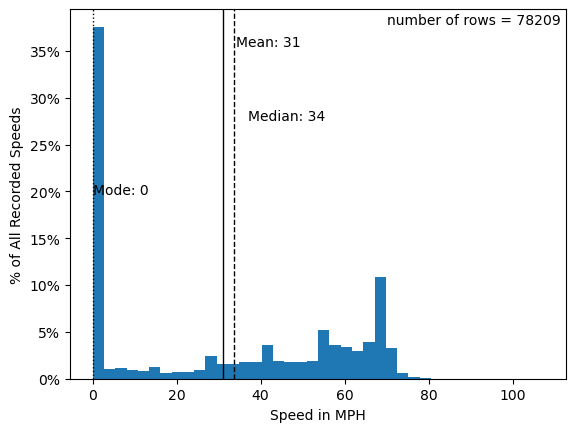

In [60]:
make_speed_hist(df.loc[:, 'mph'])

Matplotlib doesn't make the prettiest graphs, but they're functional. We can see from this initial graph that, no surpise, his most common speed was 0 mph. Still, his average recorded speed for the entire trip was 31 mph? That's either pretty impressive or is a factor related to when the phone is recording. I could see an argument that the phone records locations more when it's moving than when it's sitting. Next step is to look at his speeds only when moving.

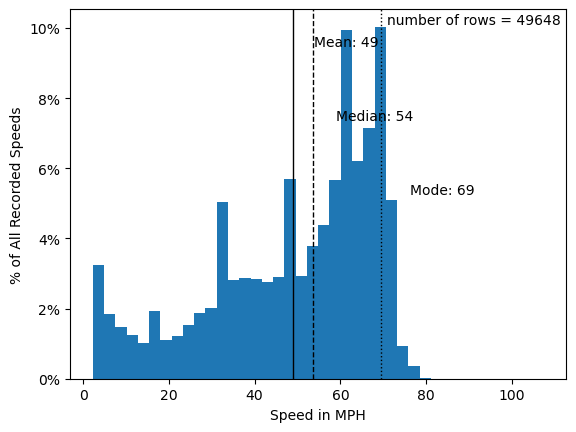

In [61]:
make_speed_hist(df.loc[df.loc[:, 'mph'] > 0, 'mph'])

It's a little funny that his modal speed is nearly 70 -- lots of highway driving, I suppose. The bumps in the histogram are probably related to the velocity units or maybe speed limits.

Now I want a map of average non-zero speed by state. He recalled (correctly) going the fastest in Montana. Did he indeed speed through the Great Plains?

[Looks like it's possible,](https://stackoverflow.com/questions/69409255/how-to-get-city-state-and-country-from-a-list-of-latitude-and-longitude-coordi) to retrieve the state for each set of coordinates using some available APIs, however that solution is rate-limited to (1 request per second)[https://operations.osmfoundation.org/policies/nominatim/].

A better solution would be to see I can categorize the coordinate points within the state polygons I use to make the underlying map. Turns out I can use a geopandas join to do just that.

In [62]:
geometry_points = [Point(xy) for xy in zip(df.loc[:, 'longitude'], df.loc[:, 'latitude'])]
gdf = gpd.GeoDataFrame(df.drop(['longitude', 'latitude'], axis=1), 
                   crs = "EPSG:4326", 
                   geometry = geometry_points)

df_w_states = gpd.sjoin(gdf, NA_map, how='left', predicate='within')
df_w_states.columns

Index(['timestampMs', 'latitudeE7', 'longitudeE7', 'accuracy', 'altitude',
       'activity', 'velocity', 'heading', 'timestamp', 'date_and_time', 'day',
       'month', 'day_alternating', 'mph', 'geometry', 'index_right', 'FID',
       'BOUND_P_', 'UIDENT', 'NAME', 'COUNTRY', 'STATEABB', 'Shape_Leng',
       'GlobalID', 'SHAPE_Le_1', 'SHAPE_Area'],
      dtype='object')

We now have a merged dataset with the geographic categories for each set of coordinates. A lot faster that 1 lookup per second!

I can now get average non-zero speed per state. I'll make the order reverse-alphabetical so the data will then appear alphabetical in the horizontal bar graph (don't ask my why that is).

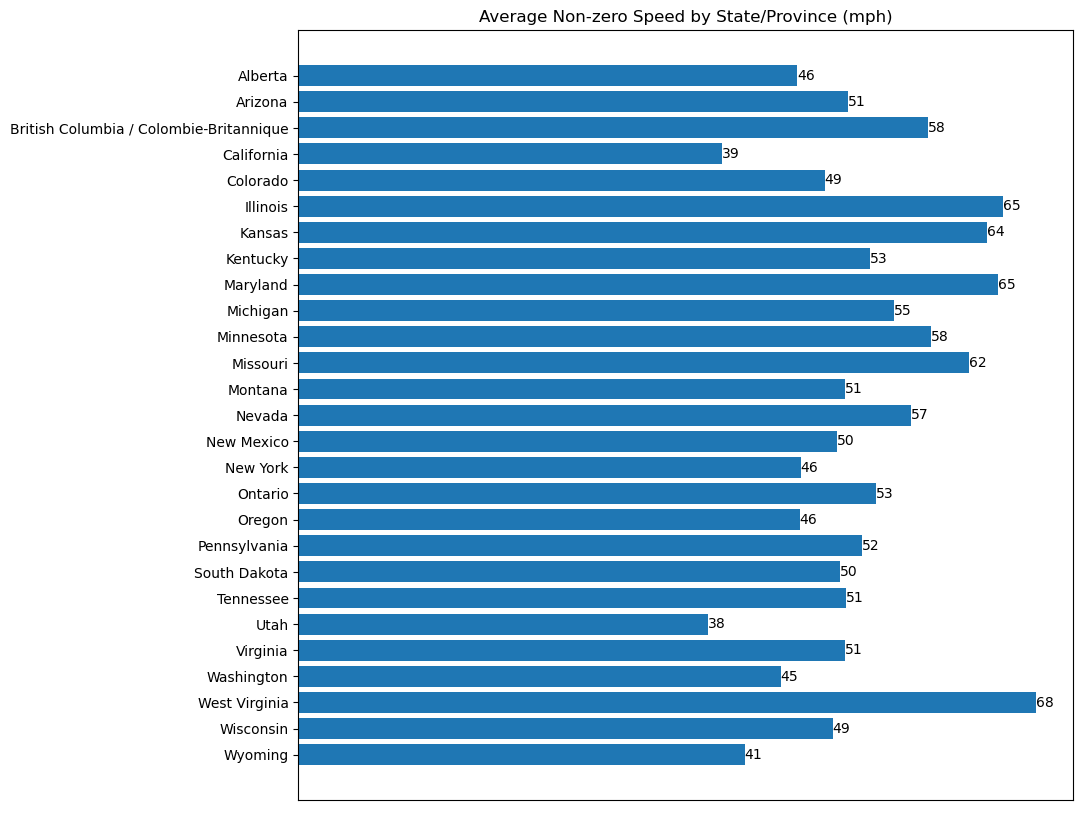

In [63]:
speed_by_state = (df_w_states.loc[df_w_states.loc[:, 'mph'] > 0]
                  .groupby('NAME').agg({'mph' : 'mean'})
                  .reset_index()
                  .sort_values('NAME', ascending=False))

fig, ax = plt.subplots(figsize = (10,10)) 
ax.barh(speed_by_state.loc[:, 'NAME'], speed_by_state.loc[:, 'mph'])
ax.bar_label(ax.containers[0], label_type='edge', fmt='%.0f')
ax.set_title("Average Non-zero Speed by State/Province (mph)")
ax.set_xticks([])

plt.show()

I'd guess that he did the most sightseeing by car in Utah and California, hence their low speeds. West Virginia and MAryland have the highest average speeds, but if we take a look back at the maps, it's because he just barely passed through them, presumably on a highway.

Finally, let's make a heat-map of speeds on the map.

# Map of Route Speeds

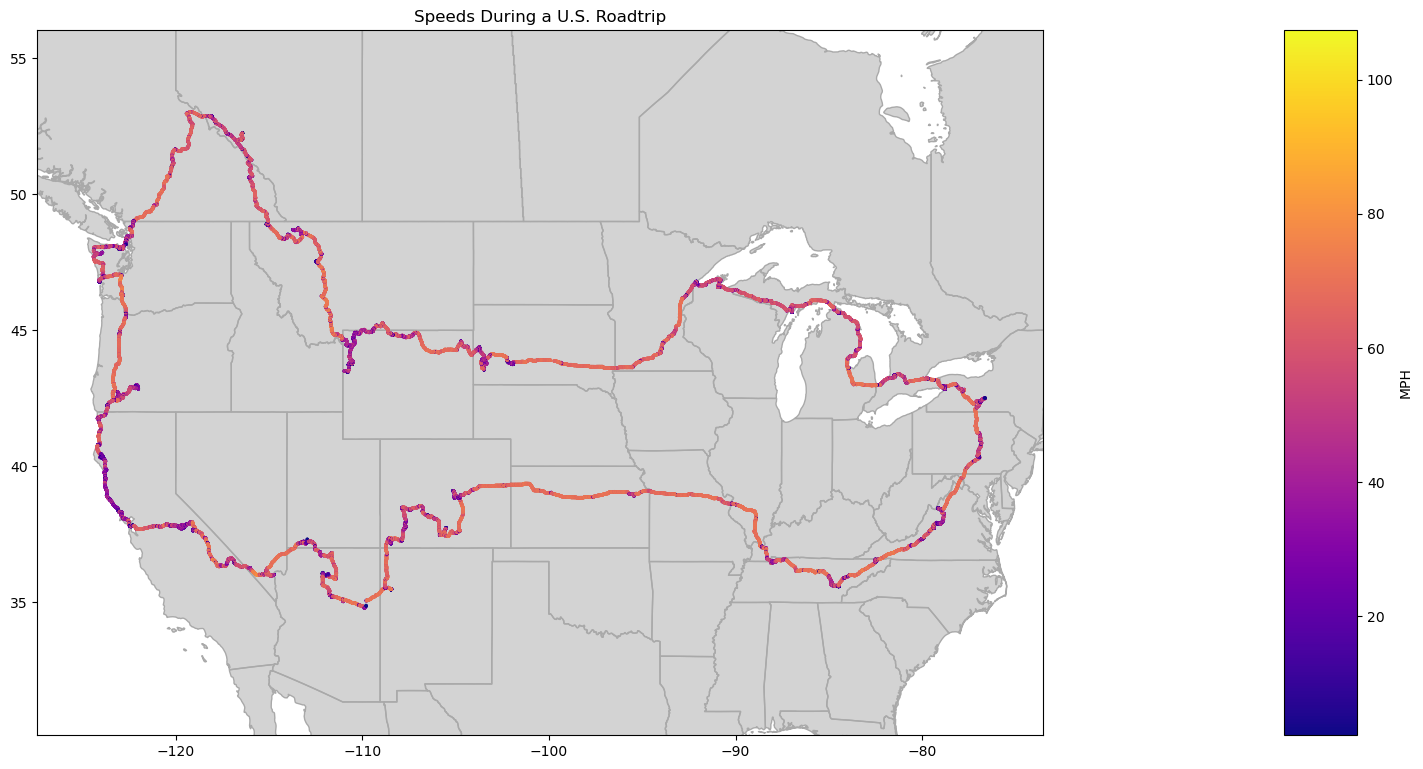

In [64]:

fig, ax = make_graph_constants((20, 20))
ax.set_title("Speeds During a U.S. Roadtrip")

# Define color of the route based on recorded speed > 0
speed_df = df.loc[df.loc[:, 'mph'] > 0]
scatter = ax.scatter(speed_df.loc[:, 'longitude'], speed_df.loc[:, 'latitude'], s = 2, c = speed_df.loc[:, 'mph'], cmap='viridis')

scatter.set_cmap('plasma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

colorbar = plt.colorbar(scatter, cax=cax)
colorbar.set_label('MPH')

plt.show()

Looks like he zoomed through the Plains states, though we can see darker points where he probably made pitstops. Looks like he made two or three in Kansas, for example. And he drove much more slowly further west when he was in mountains and/or parks.

# Final Thoughts

The maps are in a suitable place for me to stop working on them, for the moment. I shared some of the maps with my friend and he enjoyed them, found them interesting. He appreciated that the map of each day's travel showed where he stopped each night (assuming he was stopped at midnight).

There are still a few things that I could come back to and continue working of (maybe I will at some point in the future):

* The date labels in the first map are hard to read. They're not centered and frequently sit right on the line. There doesn't seem to be a rule-based way to move them from their current positions, so I could manually tweak the daily_middle_coordinates values so that the labels are in clearer locations. This would take a bit of manual trial and error.

* I'd like to better visualize points where the route overlapped. There are basically two times during the trip -- 8/27 - 8/31 and 9/11 - 9/13 -- where my friend spent some time in the same general place. As a result, the route colors are not clear and the date labels in the first map overlap. Moving the date labels around would help a bit, but that wouldn't help the route visualization itself. I could maybe jitter the scatter points, but I that would result in a less accurate map. I did look at creating an inset map of just the 8/27 - 8/31 dates, but he traveled on exactly the same roads in those dates, so zooming in on the route for those days unfortunately doesn't make the map clearer. The easiest thing to do would probably be to update the data label for that area and use one label to denote multiple days.

* Make the the maps interactive in plotly, perhaps with hover-over capaibilties. I could potentially make different layers -- altitude, speed, dates -- and have select boxes to choose what to see.

* Further, I could add more data in an interactive map. For example, I could link to pictures in Google Photos that were taken on the given day of the trip, or note the landmarks and cities that he saw along the route.

* I could clean the code up more. This notebook is pretty long; moving the functions into a .py file would make it easier to follow and cleaner.